In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm


/home/ed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [4]:
%matplotlib notebook
np.set_printoptions(precision=4, linewidth=500, threshold=500, suppress=True)

In [5]:
import sys
sys.path.append('..')

In [6]:
from model.laplacian import Laplacian
from model.features import Features
from model.targets import Targets
from model.regression.basic import LinearRegression, LassoRegression, RidgeRegression, NaiveRegression
from model.regression.glskgr import GLSKGR
from model.regression.kgr import KGR


In [7]:
laplacian = Laplacian()

In [8]:
features = Features()

In [9]:
metrics = ['Ozone', 'SO2', 'CO', 'NO2', 'PM25', 'PM10']

targets = {metric: Targets(metric) for metric in metrics}

In [24]:
model_kgr = KGR(gamma= 0.0037, K_std=90, filter_func='sigmoid', beta=62).set_laplacian(laplacian).set_data(features, targets['Ozone'])

<IPython.core.display.Javascript object>


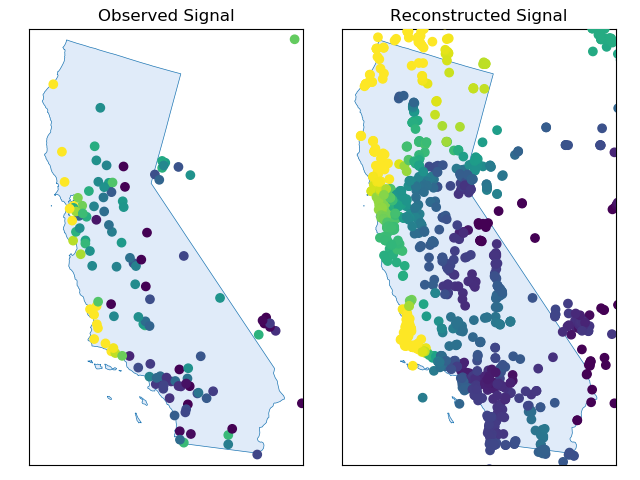

In [70]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

ti = 6
t = model_kgr.targets.Y.columns[ti]

laplacian.distance.cali.plot_outline(axes[1], dict(color='tab:blue'), fill={'fc': '#e0ebf9', 'lw': 0.5, 'ec': 'tab:blue'})
laplacian.distance.cali.plot_outline(axes[0], dict(color='tab:blue'), fill={'fc': '#e0ebf9', 'lw': 0.5, 'ec': 'tab:blue'})

vmin = np.quantile(model_kgr.targets.Y.loc[:, t], 0.1)
vmax = np.quantile(model_kgr.targets.Y.loc[:, t], 0.9)

axes[1].scatter(model_kgr.targets.sites['x'], model_kgr.targets.sites['y'], c=model_kgr.F.loc[:, t], alpha=1, vmin=vmin, vmax=vmax, zorder=np.inf)

axes[0].scatter(model_kgr.targets.sites.loc[model_kgr.targets.train_sites, 'x'], model_kgr.targets.sites.loc[model_kgr.targets.train_sites, 'y'], c=model_kgr.targets.Y.loc[:, t], alpha=1, vmin=vmin, vmax=vmax, zorder=np.inf)

axes[0].set_title('Observed Signal')
axes[1].set_title('Reconstructed Signal')

plt.tight_layout()

plt.savefig('reconstructed.pdf')




In [14]:
def get_results():
    
    models = {'KGR': KGR, 
              'LinearRegression': LinearRegression, 
              'RidgeRegression': RidgeRegression, 
              'LassoRegression': LassoRegression, 
              'GLSKGR': GLSKGR}

    init_params = {'KGR': dict(gamma=0.01, K_std=50, filter_func='sigmoid', beta=50), 
                   'LinearRegression': dict(fit_intercept=True), 
                   'RidgeRegression': dict(fit_intercept=True, alpha=50),
                   'LassoRegression': dict(fit_intercept=True, alpha=1)}


    model_names = ['KGR', 'LinearRegression', 'RidgeRegression', 'LassoRegression', 'GLSKGR']

    opt_params = {metric: {model: {} for model in model_names} for metric in metrics}

    RMSE = {'Missing Nodes':  {model: {} for model in model_names}, 
            'Labelled':       {model: {} for model in model_names}, 
            'Missing Dates':  {model: {} for model in model_names}, 
            'All Unlabelled': {model: {} for model in model_names}}

    
    metrics_bar = tqdm(metrics)

    for metric in metrics_bar:

        metrics_bar.set_description(metric)

        models_bar = tqdm(models, leave=False)

        for model in models_bar:

            models_bar.set_description(model)

            if model != 'GLSKGR':
                reg = models[model](**init_params[model])

                if model != 'KGR':
                    opt_params[metric][model] = reg.set_data(features, targets[metric]).optimize()[0]

                else:
                    opt_params[metric][model] = reg.set_laplacian(laplacian).set_data(features, targets[metric]).optimize()[0]

            else:
                reg = models['GLSKGR'](**opt_params[metric]['KGR']).set_laplacian(laplacian).set_data(features, targets[metric])
                opt_params[metric]['GLSKGR'] = opt_params[metric]['KGR']
                reg.solve_GLS()

            RMSE['Missing Nodes'][model][metric] = reg.RMSE_missing_nodes()
            RMSE['Labelled'][model][metric] = reg.RMSE_labelled()
            RMSE['Missing Dates'][model][metric] = reg.RMSE_missing_times()
            RMSE['All Unlabelled'][model][metric] = reg.RMSE_unlabelled_full()
            
    return opt_params, RMSE
            

In [15]:
opt_params, RMSE = get_results()

In [65]:
pd.DataFrame(RMSE['All Unlabelled']).T.drop('SO2', axis=1).to_csv('results/unlabelled_full.csv')

In [66]:
pd.DataFrame(RMSE['Missing Nodes']).T.drop('SO2', axis=1).to_csv('results/missing_nodes.csv')

In [67]:
pd.DataFrame(RMSE['Missing Dates']).T.drop('SO2', axis=1).to_csv('results/unlabelled_dates.csv')

In [68]:
pd.DataFrame(RMSE['Labelled']).T.drop('SO2', axis=1).to_csv('results/labelled.csv')